## Unet and Carvana data
*Note* This notebook was run on [colab](https://colab.research.google.com/)


In [1]:
!pip3 install -U albumentations
!pip3 install -U catalyst
!pip3 install -U -q PyDrive
!pip3 install safitty

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 634kB 9.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=7229639ba151ad220279279e95d7f49dd291569ed7177e1a8dd71d95df2eaa2f
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=7a07ab327951b9bb7bf2374fc94075c76be63dd17036fc62be1e4175563b2217
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 368kB 2.8MB

In [2]:
!nvidia-smi

Thu Mar 12 09:08:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# !rm -rf unet_plus_attention

In [4]:
#  zip files and upload them
from google.colab import files
uploaded = files.upload()

!unzip unet_plus_attention.zip &> /dev/null
!rm unet_plus_attention.zip

#  or using sys
import sys


sys.path.append('..')

Saving unet_plus_attention.zip to unet_plus_attention.zip


In [5]:
#  download dataset from gdrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1mRUSnaKjJwuATemYe9IN1QHAz9sPZpeT'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('masks.zip')

link = 'https://drive.google.com/open?id=1Fnzwq4In4o817PN4F1Aeefyv6DII9iUS'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.zip')

!unzip masks.zip &> /dev/null
!unzip train.zip &> /dev/null

!rm train.zip
!rm masks.zip

1mRUSnaKjJwuATemYe9IN1QHAz9sPZpeT
1Fnzwq4In4o817PN4F1Aeefyv6DII9iUS


In [6]:
from unet_plus_attention.model import get_unet_attention_decoder, get_vanila_unet_model
from unet_plus_attention.metrics import eval_iou
from unet_plus_attention.trainer import train
from unet_plus_attention.dataset import CarvanaDataset

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import os

from sklearn.model_selection import train_test_split

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


In [0]:
batch_size = 2
num_epochs = 10
lr = 1e-3
step_size = 3
gamma = 0.2

random_state = 42
test_size = 0.2

images_root = 'train'
masks_root = 'train_masks'

model_attention = get_unet_attention_decoder(3, 2)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1.,2.]))
criterion.to(device)
optim = torch.optim.Adam(model_attention.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size, gamma=gamma)

In [8]:
data_limitations = 0.2

def get_dataloaders(data_limitations):
    global images_root
    names = list(map(lambda x: x.rsplit('.', 1)[0], os.listdir(images_root)))
    train_names, val_names = train_test_split(names, random_state=random_state, test_size=test_size)
    np.random.shuffle(train_names)
    np.random.shuffle(val_names)
    train_names = train_names[:int(len(train_names) * data_limitations)]
    val_names = val_names[:int(len(val_names) * data_limitations)]

    print(f"Train: {len(train_names)}\nVal: {len(val_names)}")
    train_dataset = CarvanaDataset(train_names, images_root, masks_root)
    val_dataset = CarvanaDataset(val_names, images_root, masks_root)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = get_dataloaders(data_limitations)

Train: 814
Val: 203


In [9]:
from torchsummary import summary

summary(model_attention.to(device), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
            Conv2d-7        [-1, 128, 256, 256]          73,856
       BatchNorm2d-8        [-1, 128, 256, 256]             256
              ReLU-9        [-1, 128, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]         147,584
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 256, 128, 128]         295,168
      BatchNorm2d-14        [-1, 256, 1

In [10]:
import gc


gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Thu Mar 12 09:10:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    39W / 250W |    819MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train: 0.022029682559119104
Validation: 0.022562655611146315


No handles with labels found to put in legend.


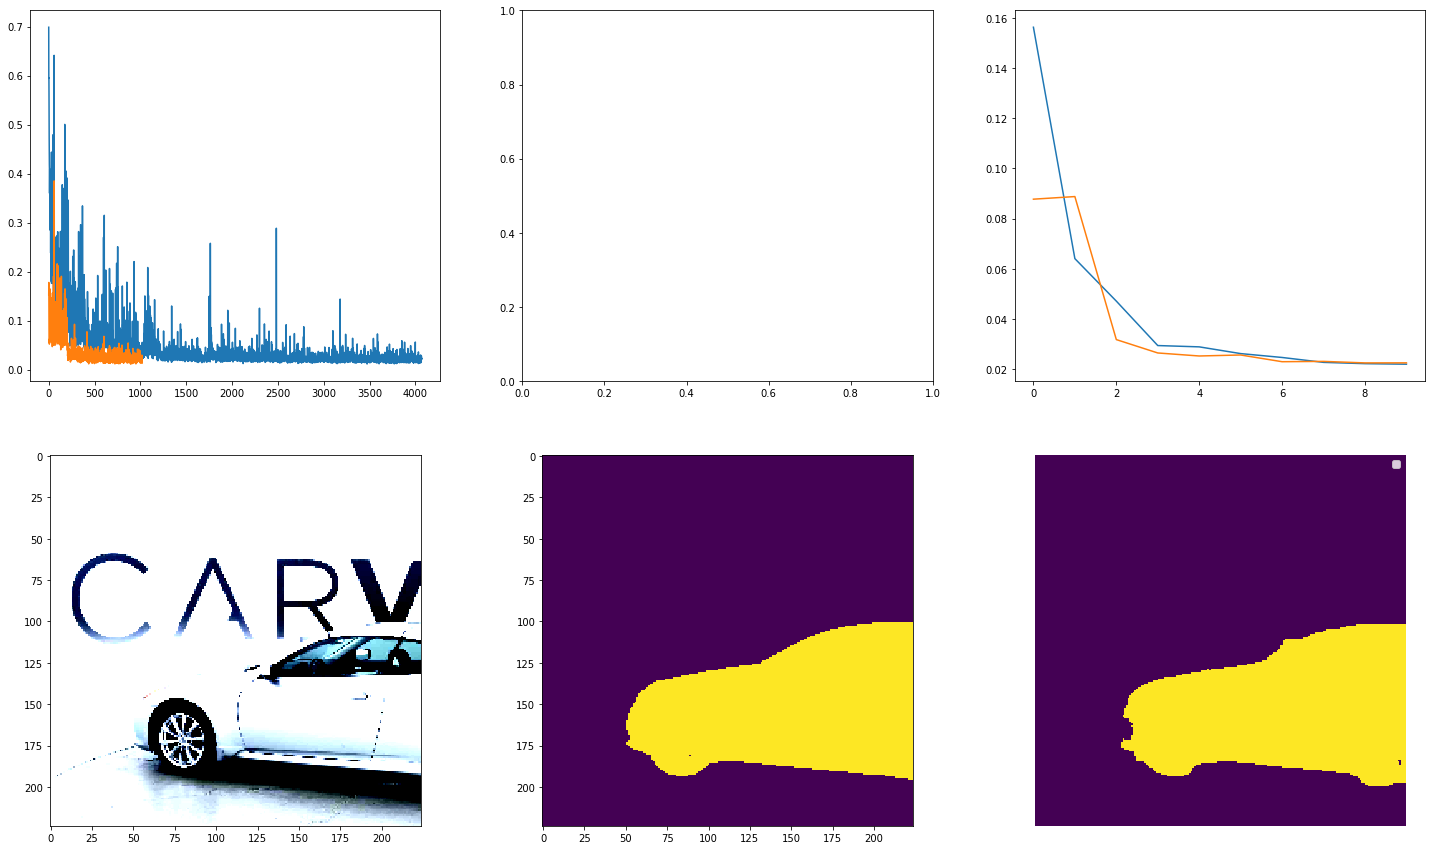

CPU times: user 17min 21s, sys: 10min 38s, total: 27min 59s
Wall time: 27min 57s


In [12]:
%%time

attn_hist = train(model_attention, optim, criterion, train_dataloader, val_dataloader, scheduler, device, num_epochs, verbose=True)

In [13]:
model_attention.load_state_dict(torch.load('best_model.pth'))
attention_score = eval_iou(model_attention, val_dataloader, device, verbose=False)
print(f"Attention: {attention_score}")

Attention: 0.9723921575967003


In [14]:
del model_attention
gc.collect()
torch.cuda.empty_cache()

!nvidia-smi

Thu Mar 12 09:38:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    53W / 250W |   1121MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# VANILA UNET

In [0]:
batch_size = 2
num_epochs = 10
lr = 1e-3
step_size = 3
gamma = 0.2

random_state = 42
test_size = 0.2

images_root = 'train'
masks_root = 'train_masks'
model_vanilla = get_vanila_unet_model(3, 2)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1.,2.]))
criterion.to(device)
optim = torch.optim.Adam(model_vanilla.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size, gamma=gamma)

In [17]:
summary(model_vanilla.to(device), (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
            Conv2d-7        [-1, 128, 256, 256]          73,856
       BatchNorm2d-8        [-1, 128, 256, 256]             256
              ReLU-9        [-1, 128, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]         147,584
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 256, 128, 128]         295,168
      BatchNorm2d-14        [-1, 256, 1

In [18]:
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Thu Mar 12 09:38:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    52W / 250W |    855MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Train: 0.024185411112625562
Validation: 0.02251773039061649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.


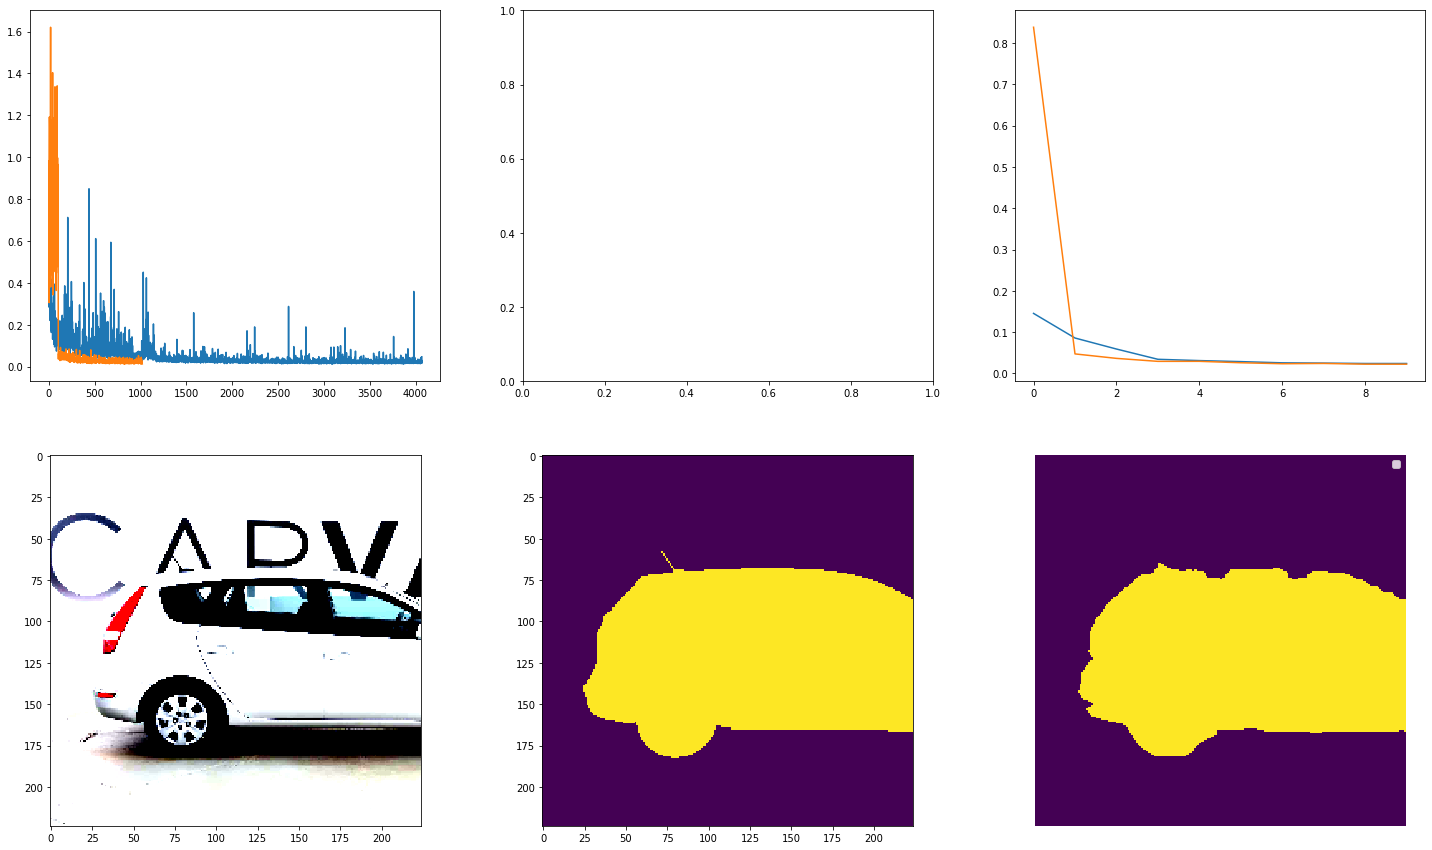

CPU times: user 12min 21s, sys: 4min 3s, total: 16min 25s
Wall time: 16min 16s


In [19]:
%%time

vanilla_hist = train(model_vanilla, optim, criterion, train_dataloader, val_dataloader, scheduler, device, num_epochs, verbose=True)

In [20]:
model_vanilla.load_state_dict(torch.load('best_model.pth'))
vanilla_score = eval_iou(model_vanilla, val_dataloader, device, verbose=False)
print(f"Vanilla: {vanilla_score}")

Vanilla: 0.9698427348744636
